In [115]:
import numpy as np
from typing import Iterable, Set, Tuple, List
from itertools import combinations
from math import inf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [116]:
Rect1D = Tuple[int, int, int]        # (start_time, end_time, bandwidth)
Rect2D = Tuple[int, int, int, int]   # (x1, x2, y1, y2)
Slots1D = Iterable[Rect1D]
Slots2D = Set[Rect2D]

In [117]:
# unavailable_slots：(start_time, end_time, bandwidth)
unavailable_slots = {(10, 13, 50), (15, 30, 75)}
# total_slots：(start_time, end_time, bandwidth)
total_slots = {(0, 30, 100)}
# request r：(size, priority)
request_r  = [(300, 5), (200, 2), (600, 1)]

In [118]:
#Tracking Bandwidth Usage
current_bandwidth_usage = {}  # {time_point: current_max_bandwidth_used}

def get_current_max_bandwidth(x1, x2):
    """Get the current maximum bandwidth used in the time range [x1, x2]"""
    max_used = 0
    for t in range(x1, x2):
        max_used = max(max_used, current_bandwidth_usage.get(t, 0))
    return max_used

def update_bandwidth_usage(x1, x2, y1, y2):
    """Update the bandwidth usage for the time range [x1, x2]"""
    for t in range(x1, x2):
        current_bandwidth_usage[t] = max(current_bandwidth_usage.get(t, 0), y2)

In [119]:
def get_next_slot(unavailable: Slots1D, total: Slots1D) -> List[Rect2D]:
    """
    Compute available regions by subtracting unavailable from total,
    resulting in available bandwidth rectangle regions
    """
    res: Slots2D = set()
    for t_x1, t_x2, t_h in total:
        y_breaks = {0, t_h}
        y_breaks.update(uh for _, _, uh in unavailable if uh < t_h)
        y_sorted = sorted(y_breaks)
        for idx, y1 in enumerate(y_sorted[:-1]):
            next_y, last_y = y_sorted[idx + 1], y_sorted[-1]
            for y2 in (next_y, last_y):
                if y2 <= y1:
                    continue
                x2_limit = t_x2
                for u_x1, _, u_h in sorted(unavailable, key=lambda u: u[0]):
                    if u_h > y1 and u_x1 < x2_limit:
                        x2_limit = u_x1
                        break
                res.add((t_x1, x2_limit, y1, y2))
    return sorted(res, key=lambda r: (r[2], r[0], -r[3], r[1]))

In [120]:
def compute_slot_areas(slots: List[Rect2D]) -> List[int]:
    """Compute area of each slot for available list"""
    return [(x2 - x1) * (y2 - y1) for x1, x2, y1, y2 in slots]

In [121]:
slot_areas = compute_slot_areas(get_next_slot(unavailable_slots, total_slots))
slot_areas

[1000, 500, 750, 375, 750]

In [122]:
def r_sorted_by_area(rules: List[Tuple[int, int]], reverse: bool = False) -> List[Tuple[int, int]]:
    """
    Generate [(size, r_id)] sorted by size
    :param rules: [(size, priority)]
    :param reverse: whether to sort in descending order
    :return: [(size, r_id)]
    """
    r_with_index = [(size, idx + 1) for idx, (size, _) in enumerate(rules)]
    return sorted(r_with_index, key=lambda x: x[0], reverse=reverse)

# Replace old inserted_r -> rules
request_areas = r_sorted_by_area(request_r)

In [123]:
def ordinal(n: int) -> str:
    """Return ordinal string, e.g., 1->1st, 2->2nd"""
    return f"{n}{'st' if n==1 else 'nd' if n==2 else 'rd' if n==3 else 'th'}"

In [124]:
def can_fit_all_remaining_requests(r_remaining, current_slot_area):
    r_sum = sum(area for area, _ in r_remaining)
    return r_sum <= current_slot_area

In [125]:
def allocate_requests_in_slot(slot_rect, requests):
    """Fixed allocation function that correctly handles bandwidth stacking"""
    allocation = []
    wasted = []
    x1, x2, y1, y2 = slot_rect
    width = x2 - x1

    # Get the current maximum used bandwidth in the time period
    current_max_used = get_current_max_bandwidth(x1, x2)

    # Start allocation from the max(current, y1) 
    y_cursor = max(y1, current_max_used)

    for area, rid in requests:
        h = area / width
        allocation.append((x1, x2, y_cursor, y_cursor + h, rid))
        # Update bandwidth usage
        update_bandwidth_usage(x1, x2, y_cursor, y_cursor + h)
        y_cursor += h
    # Calculate unused area
    if y_cursor < y2:
        wasted.append((x1, x2, y_cursor, y2))

    return allocation, wasted


In [126]:
def find_best_fit_groups(r_remaining, current_slot_area):
    best_under, best_under_sum = (), 0
    best_over, best_over_sum = (), inf
    for n in range(1, len(r_remaining) + 1):
        for combo in combinations(r_remaining, n):
            s = sum(area for area, _ in combo)
            # best fit within capacity
            if s <= current_slot_area and s > best_under_sum:
                best_under, best_under_sum = combo, s
                if s == current_slot_area:
                    break
            # best fit over capacity
            elif s > current_slot_area and s < best_over_sum:
                best_over, best_over_sum = combo, s
        # find the perfect fit
        if best_under_sum == current_slot_area:
            break
    return best_under, best_under_sum, best_over, best_over_sum

In [127]:
def evaluate_blank2_area(best_over_sum, current_slot_area, current_slot_rect, next_slot_rect):
    x1, x2, y1, y2 = current_slot_rect
    width = x2 - x1
    overflow_h = (best_over_sum - current_slot_area) / width
    if not next_slot_rect:
        return inf
    next_x1, next_x2, _, _ = next_slot_rect
    return overflow_h * abs(next_x2 - x2)

In [128]:
def apply_overflow_penalty_to_next_slots(slot_rects, slot_area_list, i, delta_h):
    for j in (i + 1, i + 2):
        if j >= len(slot_rects):
            break
        x1, x2, y1, y2 = slot_rects[j]
        new_y2 = y2 - delta_h
        if new_y2 <= y1:
            slot_rects.pop(j)
            slot_area_list.pop(j)
        else:
            slot_rects[j] = (x1, x2, y1, new_y2)
            slot_area_list[j] = (x2 - x1) * (new_y2 - y1)

In [129]:
def calculate_priority_bandwidth_ratio(original_prio, priority):
    """
    Higher priority (larger number) gets more bandwidth
    """
    # check if the request list have the same priority, if yes, with same width
    unique_priorities = sorted(set(priority), reverse=True)
    if len(unique_priorities) == 1:
        return 1.0

    return float(original_prio)

In [130]:
def allocate_requests_fill_bandwidth(slot_rect, requests):
    """
    TODO COMPLETED: Priority-based bandwidth allocation
    Calculate height first based on priority ratio, then calculate individual widths
    Each request gets different width based on its size/height ratio
    """
    allocation = []
    wasted = []
    x1, x2, y1, y2 = slot_rect

    # Get current max bandwidth usage
    max_used_bandwidth = get_current_max_bandwidth(int(x1), int(x2))
    effective_y1 = max(y1, max_used_bandwidth)
    effective_height = y2 - effective_y1

    if effective_height <= 0 or not requests:
        if effective_height <= 0:
            wasted.append((x1, x2, y1, y2))
        return allocation, wasted

    # Check if this is the final allocation where all remaining requests fit
    total_size = sum(area for area, _ in requests)

    #if there is only one left, then fit the rest of bandwidth
    if len(requests) == 1:
        area, rid = requests[0]
        # Use all available bandwidth height for the single request
        height = effective_height
        width = area / height if height > 0 else 0

        # Ensure width doesn't exceed slot width
        slot_width = x2 - x1
        if width > slot_width:
            width = slot_width
            height = area / width if width > 0 else 0

        x_end = x1 + width
        y_end = effective_y1 + height

        allocation.append((x1, x_end, effective_y1, y_end, rid))
        update_bandwidth_usage(int(x1), int(x_end), effective_y1, y_end)

        # Calculate unused area if any
        if y_end < y2:
            wasted.append((x1, x2, y_end, y2))

        return allocation, wasted
    # By priority, determine the area
    if len(requests) > 1 and total_size <= (effective_height * (x2 - x1)):
        # get the all priorities and calculate ratios
        all_priorities = [request_r[rid - 1][1] for area, rid in requests]
        request_data = []
        total_priority_sum = 0

        for area, rid in requests:
            original_priority = request_r[rid - 1][1]  # rid is 1-indexed
            priority_ratio = calculate_priority_bandwidth_ratio(original_priority, all_priorities)
            total_priority_sum += priority_ratio

            request_data.append({
                'area': area,
                'rid': rid,
                'priority': original_priority,
                'ratio': priority_ratio
            })

        # calculate height for based on priority ratio
        y_cursor = effective_y1
        max_width_needed = 0

        for req_data in request_data:
            height_ratio = req_data['ratio'] / total_priority_sum
            height = effective_height * height_ratio

            width = req_data['area'] / height if height > 0 else 0
            max_width_needed = max(max_width_needed, width)

            req_data['height'] = height
            req_data['width'] = width

        # Check if all requests can fit within the slot width
        slot_width = x2 - x1
        if max_width_needed <= slot_width:
            # All requests fit, allocate with individual widths
            for req_data in request_data:
                width = req_data['width']
                height = req_data['height']

                x_end = x1 + width
                y_end = y_cursor + height

                allocation.append((x1, x_end, y_cursor, y_end, req_data['rid']))
                update_bandwidth_usage(int(x1), int(x_end), y_cursor, y_end)

                y_cursor = y_end

        else:
            # Not all requests fit with individual widths, scale down proportionally
            scale_factor = slot_width / max_width_needed

            for req_data in request_data:
                width = req_data['width'] * scale_factor
                height = req_data['height']

                x_end = x1 + width
                y_end = y_cursor + height

                allocation.append((x1, x_end, y_cursor, y_end, req_data['rid']))
                update_bandwidth_usage(int(x1), int(x_end), y_cursor, y_end)
                y_cursor = y_end

    else:
        return allocate_requests_in_slot(slot_rect, requests)

    return allocation, wasted

In [131]:
def find_r_slot_with_allocation(
    r_list: List[Tuple[int, int]],
    slot_area_list: List[int],
    slot_rects: List[Rect2D]
) -> Tuple[List[str], List[Tuple[int, int, float, float, int]], List[Rect2D], float, float]:
    # Reset global bandwidth usage
    global current_bandwidth_usage
    current_bandwidth_usage = {}

    # Initialize bandwidth usage with unavailable slots
    for x1, x2, h in unavailable_slots:
        for t in range(x1, x2):
            current_bandwidth_usage[t] = h

    result = []
    r_remaining = r_list[:]
    allocation = []
    wasted = []

    total_r_area = sum(area for area, _ in r_remaining)
    even_slot_sum = sum(slot_area_list[i] for i in range(1, len(slot_area_list)-1, 2)) if len(slot_area_list) > 1 else 0
    last_slot_area = slot_area_list[-1] if slot_area_list else 0
    total_available_area = even_slot_sum + last_slot_area

    slot_index = 1
    i = 0
    compare_mode = True

    while r_remaining and i < len(slot_area_list):
        current_slot_area = slot_area_list[i]
        current_slot_rect = slot_rects[i]
        #print(current_slot_rect)

        if compare_mode:
            # check if all remaining requests fit
            if can_fit_all_remaining_requests(r_remaining, current_slot_area):
                result.append(f"All remaining requests {r_remaining} fitted in the {ordinal(slot_index)} area")

                alloc, waste = allocate_requests_fill_bandwidth(current_slot_rect, r_remaining)
                allocation.extend(alloc)
                wasted.extend(waste)
                return result, allocation, wasted, total_available_area, total_r_area
            # Move to next slot
            i += 1
            slot_index += 1
            compare_mode = False
            continue
        #find best fit for current slot
        best_under, best_under_sum, best_over, best_over_sum = find_best_fit_groups(r_remaining, current_slot_area)
        #print(f"  best_under: {best_under}, sum: {best_under_sum}")
        #print(f"  best_over: {best_over}, sum: {best_over_sum}")

        #Calculate waste
        blank_1 = (current_slot_area - best_under_sum) if best_under else inf
        blank_2 = inf
        if best_over and i + 1 < len(slot_rects):
            blank_2 = evaluate_blank2_area(best_over_sum, current_slot_area, current_slot_rect, slot_rects[i + 1])

        #print(f"  blank_1: {blank_1}, blank_2: {blank_2}")

        if best_under and best_under_sum <= current_slot_area:
            best_fit_group = best_under
            #print(f"  Choose best_under: {best_fit_group}")
        elif best_over and blank_2 < current_slot_area:
            best_fit_group = best_over
            #print(f" Choose best_over: {best_fit_group}")
        else:
            # Skip if no fitted set of requests
            result.append(f"No requests fit in the {ordinal(slot_index)} area")
            #print(f"Skip the area")
            i += 1
            slot_index += 1
            compare_mode = True
            continue

        result.append(f"Requests {list(best_fit_group)} fitted in the {ordinal(slot_index)} area")
        alloc, waste = allocate_requests_in_slot(current_slot_rect, best_fit_group)
        allocation.extend(alloc)
        wasted.extend(waste)
        # Remove allocated requests from remaining list
        for val in best_fit_group:
            r_remaining.remove(val)

        if best_fit_group == best_over and i + 1 < len(slot_rects):
            x1, x2, _, _ = current_slot_rect
            delta_h = (best_over_sum - current_slot_area) / (x2 - x1)
            apply_overflow_penalty_to_next_slots(slot_rects, slot_area_list, i, delta_h)

        i += 1
        slot_index += 1
        compare_mode = True
    # all the remaining unallocated requests in the last slot
    if r_remaining:
        result.append(f"These requests fit in the last area: {r_remaining}")
        alloc, waste = allocate_requests_in_slot(slot_rects[-1], r_remaining)
        allocation.extend(alloc)
        wasted.extend(waste)

    return result, allocation, wasted, total_available_area, total_r_area

In [132]:
def visualize_integrated_schedule(request_r, unavailable_slots, total_slots, allocations, waste_rects):
    """
    Integrated visualization function that combines both approaches
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    max_time = 0
    if unavailable_slots:
        max_time = max(max_time, max(end for _, end, _ in unavailable_slots))
    if allocations:
        max_time = max(max_time, max(x2 for x1, x2, _, _, _ in allocations))
    max_time = max(max_time, 30)  # Minimum time range
    
    # Get bandwidth from total_slots
    total_bandwidth = next(iter(total_slots))[2] if total_slots else 100
    
    # total area boundary
    for x1, x2, h in total_slots:
        ax.add_patch(patches.Rectangle((x1, 0), x2 - x1, h, 
                                     fill=False, edgecolor='black', linewidth=2))
    
    # unavailable slots
    for x1, x2, h in unavailable_slots:
        ax.add_patch(patches.Rectangle((x1, 0), x2 - x1, h, 
                                     color='red', alpha=0.6, label="Unavailable"))
        ax.text((x1 + x2) / 2, h/2, f'Reserved\n{h} BW', 
               ha='center', va='center', fontsize=8, color='white', weight='bold')
    
    # allocated requests
    for x1, x2, y1, y2, rid in allocations:
        ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1, 
                                     color='blue', alpha=0.7))

        size, priority = request_r[rid - 1]
        height = y2 - y1
        width = x2 - x1

        label = f'R{rid}\nSize: {size}\nPrio: {priority}\nBW: {height:.1f}'
        ax.text(x1 + width/2, y1 + height/2, label, 
               ha='center', va='center', fontsize=8, color='white', weight='bold')
    
    info_x = max_time + 2
    info_y = total_bandwidth - 5
    dy = total_bandwidth / 15
    
    ax.text(info_x, info_y, "Requests (size, priority, height):", fontsize=10, weight='bold')
    info_y -= dy

    rid_to_height = {}
    for x1, x2, y1, y2, rid in allocations:
        height = y2 - y1
        rid_to_height[rid] = height
    
    for i, (size, priority) in enumerate(request_r, 1):
        height = f"{rid_to_height.get(i, 0):.1f}" if i in rid_to_height else "0"
        ax.text(info_x, info_y, f"R{i}: ({size}, {priority}, {height})", fontsize=9)
        info_y -= dy
    
    ax.set_xlim(0, max_time + 8)
    ax.set_ylim(0, total_bandwidth + 5)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Bandwidth', fontsize=12)
    ax.set_title('Integrated Bandwidth Allocation Visualization', fontsize=14, weight='bold')
    ax.grid(True, alpha=0.3)
    
    handles = []
    if unavailable_slots:
        handles.append(patches.Patch(color='red', alpha=0.6, label='Unavailable/Reserved'))
    if allocations:
        handles.append(patches.Patch(color='blue', alpha=0.7, label='Allocated Requests')) 
    if handles:
        ax.legend(handles=handles, loc='upper right')
    
    plt.tight_layout()
    plt.show()



--- Allocation Details ---
R2: time [0.0, 10.0], bandwidth [0.00, 20.00], height: 20.00
R1: time [0.0, 10.0], bandwidth [20.00, 50.00], height: 30.00
R3: time [0.0, 12.0], bandwidth [50.00, 100.00], height: 50.00


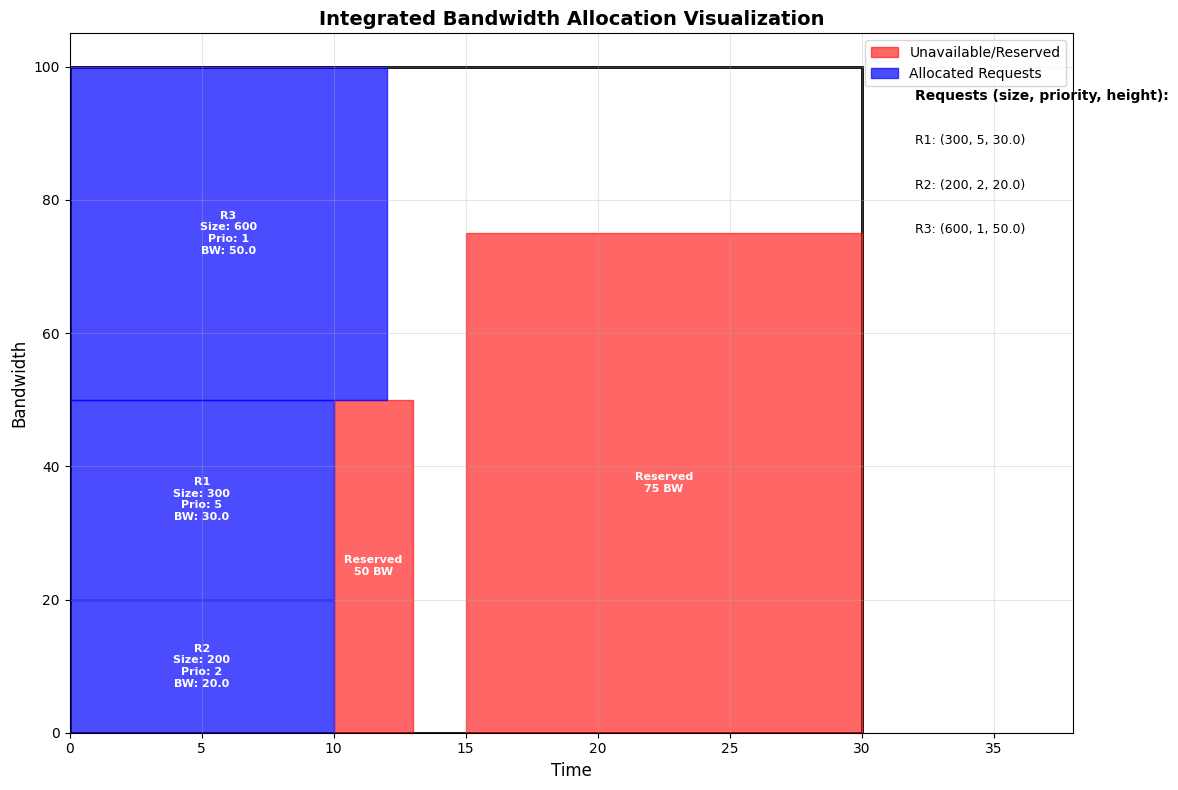

In [133]:
if __name__ == "__main__":
    slot_rects = get_next_slot(unavailable_slots, total_slots)
    slot_areas = compute_slot_areas(slot_rects)
    request_areas = r_sorted_by_area(request_r)
    
    result_texts, allocations, waste_rects, total_available_area, total_r_area = find_r_slot_with_allocation(
        request_areas, slot_areas, slot_rects)
    
    
    print("\n--- Allocation Details ---")
    for x1, x2, y1, y2, rid in allocations:
        print(f"R{rid}: time [{x1:.1f}, {x2:.1f}], bandwidth [{y1:.2f}, {y2:.2f}], height: {y2-y1:.2f}")
    
    if total_available_area < total_r_area:
        print(f"\nWarning: Need to extend space (available: {total_available_area}, required: {total_r_area})")
    
    # 显示可视化
    visualize_integrated_schedule(request_r, unavailable_slots, total_slots, allocations, waste_rects)